In [1]:
print('https://www.whatismybrowser.com/detect/what-is-my-user-agent/')

https://www.whatismybrowser.com/detect/what-is-my-user-agent/


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os, sys
import shutil
import cv2

from tqdm.notebook import tqdm 
from google.colab import drive
from datetime import datetime
from pytz import timezone
from glob import glob 

drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/collage')

# 구글 드라이브 내에 필요 패키지 설치를 위한 경로 설정 
try:
    os.mkdir('./packages')
except:
    print('-')
link_name = '/packages'
target = '/content/drive/My Drive/Colab Notebooks/collage/packages'
try:
  os.symlink(target, link_name)
except:
  os.chdir(target)
  os.remove(link_name)
  os.symlink(target, link_name)
sys.path.insert(0, link_name)

# 스크래핑에 필요한 헤더정보 정의
# 실행을 위해서는 각 환경에 맞는 유저에이전트 정보 필요 
headers = {'user-agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.0.0 Safari/537.36'}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
-


In [3]:
## 필요 패키지 설치
# !pip --version
# !pip install --target=$link_name --upgrade pip
# !pip install --target=$link_name --use-deprecated=legacy-resolver git+https://github.com/kakaobrain/pororo.git
# !pip install --target=$link_name konlpy
# !pip install --target=$link_name python-mecab-ko
# !pip install --target=$link_name kollocate
# !pip install --target=$link_name koparadigm1
# !pip install --target=$link_name g2pk
# !pip install --target=$link_name selenium
# !pip install --target=$link_name webdriver_manager
# !pip install --target=$link_name cairosvg
## 셀레니움 스크래핑에 필요한 크롬 드라이버 설치 
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency t

In [4]:
# 설치한 자연어 처리모듈 뽀로로 및 직접정의한 py파일들 로드 / py파일에서 정의한 모든 주석은 각 py파일에 포함함
from pororo import Pororo

os.chdir('/content/drive/MyDrive/Colab Notebooks/collage')
import cairosvg 
import arrange
import scrap
import seg

# 자연어 처리 객체를 미리 생성
summ = Pororo(task="summarization", model="abstractive", lang="ko")
se = Pororo(task="sentence_embedding")
ner = Pororo(task="ner", lang="ko")

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


In [5]:
# 산출물을 담을 딕셔너리 생성
def return_trend_dict():
  '''
  산출물을 담을 딕셔너리 생성 앞으로 return_dict라 칭할예정
  '''
  return {'keyword': None, 'namuKeyword': None, 'namuKeyword_kind': None, 'articles': None, 'links':None, 'title_picked':None, 'article_summary':None, 'img_name':None, 'img':None, 'img_coor':None}

In [6]:
from google.colab import output
output.enable_custom_widget_manager()

In [7]:
# 시간 구분을 위함 
now = datetime.now(timezone('Asia/Seoul'))
datetime_text = str(now.strftime('%y-%m-%d-%H:%M'))

keyword_dicts = []
keyword_now = scrap.scrapSignalKeyword()

print(f'{datetime_text} : {keyword_now}')
for idx, keyword in tqdm(enumerate(keyword_now)):
  dict_ = return_trend_dict()
  articles, links = scrap.scrapNaverNewsKeyword(keyword, article_num=8, headers=headers, sort='1', length=350)
  # 원검색어
  dict_['keyword'] = keyword
  # 검색어에 대응하는 (제목, 내용)의 리스트
  dict_['articles'] = articles
  # 앞으로 이미지 파일을 저장할 파일 이름
  dict_['img_name'] = str(idx) + '.png'
  # 기사들에 대응하는 링크들
  dict_['links'] = links
  keyword_dicts.append(dict_)

22-08-23-12:01 : ['이기우', '맨유 리버풀', '모텔 아기 살해한', '가방 경찰 공조', '처서', '파티 핀란드 총리', '이준석', '尹 세모녀처럼 특단조치', '코요태', '서민재']


0it [00:00, ?it/s]

In [8]:
# 한자어들 대체
def keyword_replace(txt):
  '''
  txt : str / 대체될 텍스트
  '''
  per_dict = { '尹':'윤석열', '文':'문재인', '與': '국민의힘', '野': '더불어민주당', }
  for word, replacement in per_dict.items():
    txt = txt.replace(word, replacement)
  return txt

In [9]:
def find_namukey(keyword, check_all=False):
  '''
  텍스트에서 ner이후 나무위키에서 사진을 가지고올 키워드들을 찾아내기 위한 함수
  인물을 우선적으로 추출

  keyword : 사진을 찾을 검색어를 찾으
  '''
  # 단어를 대체
  ner_result = ner(keyword_replace(keyword))
  ner_person_list = [re[0] for re in ner_result if re[1]=='PERSON']
  ner_or_list = [re[0] for re in ner_result if re[1]=='ORGANIZATION']
  ner_arti_list = [re[0] for re in ner_result if re[1]=='ARTIFACT']
  ner_city_list = [re[0] for re in ner_result if re[1]=='CITY']
  # 인물 키워드 뿐만 아니라 기관이나 도시같은 키워드도 반환
  if check_all:
    if len(ner_person_list) > 0:
      for p in ner_person_list:
        if keyword == p:
          return p, 'person'
      return ner_person_list[0], 'person'

    elif len(ner_or_list) > 0:
      for o in ner_or_list:
        if keyword == o:
          return o, 'organization'
      return ner_or_list[0], 'organization'

    elif len(ner_arti_list) > 0:
      for a in ner_arti_list:
        if keyword == a:
          return a, 'artifact'
      return ner_arti_list[0], 'artifact'

    elif len(ner_city_list) > 0:
      for c in ner_city_list:
        if keyword == c:
          return c, 'city'
      return ner_city_list[0], 'city'
    else :
      return keyword, '-'
  else:
    if len(ner_person_list) > 0:
      for p in ner_person_list:
        if keyword == p:
          return p, 'person'
      return ner_person_list[0], 'person'
    else :
      return keyword, '-'

In [10]:
# 각 검색어마다 나무위키에 검색할 키워드와 키워드의 종류를 할당
for dict_ in tqdm(keyword_dicts):
  dict_['namuKeyword'], dict_['namuKeyword_kind'] = find_namukey(dict_['keyword'])
  # dict_['namuKeyword'], dict_['namuKeyword_kind'] = '-', '-'

  0%|          | 0/10 [00:00<?, ?it/s]

In [11]:
print([k['namuKeyword'] for k in keyword_dicts])

['이기우', '맨유 리버풀', '모텔 아기 살해한', '가방 경찰 공조', '처서', '파티', '이준석', '윤석열', '코요태', '서민재']


In [12]:
from sklearn.metrics.pairwise import cosine_similarity

def find_impor_title_idx(dict_):
  '''
  리턴 딕셔너리를 받아 해당 제목들의 cosine similarity를 구하여 스코어가 가장 높은 았던 제목의 인덱스를 반환하는 함수
  스코어가 가장 높은 제목이 현재의 이슈에 대한 내용을 담을 것이라는 가정하에 여러 기사들 사이에서 공통적인 내용을 의미하는 기사를 찾기 위함 

  dict_ : return_dict  
  '''

  titles = [keyword_replace(article[0].strip()) for article in dict_['articles']]
  titles_embedding = [se(t).reshape(1,-1) for t in titles]

  sims = []
  for i in range(len(titles_embedding)):
    cands = titles_embedding.copy()
    query = cands.pop(i)
    temp_num = 0
    for c in cands:
      temp_num += cosine_similarity(query, c)[0][0]
    sims.append(temp_num)
  max_ = max(sims)
  max_idx = sims.index(max_)

  return max_idx

In [13]:
def namukeyword_replace(txt):
  '''
  txt : str / 대체될 텍스트
  '''
  per_dict = { '검찰':'검찰청', '교직원공제회': '한국교직원공제회', '제주' : '제주특별자치도',  '경찰' : '대한민국 경찰청'}
  for word, replacement in per_dict.items():
    txt = txt.replace(word, replacement)
  return txt

In [14]:
for dict_ in tqdm(keyword_dicts):
  max_idx = find_impor_title_idx(dict_)
  dict_['title_picked'] = max_idx
  if dict_['namuKeyword_kind']=='-':
    # 적절한 검색키워드를 찾지 못한 경우 cosine_similarity가 가장 높았던 
    target_title = dict_['articles'][max_idx][0]
    dict_['namuKeyword'], dict_['namuKeyword_kind'] = find_namukey(target_title, check_all=True)
    dict_['namuKeyword'] = namukeyword_replace(dict_['namuKeyword'])


  dict_['article_summary'] = summ(dict_['articles'][max_idx][1],
                                  beam=5, 
                                  len_penalty=3,
                                  no_repeat_ngram_size=3,
                                  top_k=50,
                                  top_p=0.7,
                                  temperature=1.5
                                  )
  if dict_['namuKeyword_kind']=='-':
    target_content = dict_['article_summary']
    dict_['namuKeyword'], dict_['namuKeyword_kind'] = find_namukey(target_content, check_all=True)
    dict_['namuKeyword'] = namukeyword_replace(dict_['namuKeyword'])

  0%|          | 0/10 [00:00<?, ?it/s]

In [15]:
print([k['namuKeyword'] for k in keyword_dicts])

['이기우', '반 다이크', '만안대한민국 경찰청서', '대한민국 경찰청', "가을의 두 번째 절기 '처서'에 접어들었지만, 여전히 더위의 기세는 여전하며,비가 내린 뒤 습도가 잔뜩 올라가 있고 체감 온도는 32도까지 치솟으며 무척 끈적하며,오늘도 옷차림 시원하게 하시는 등 더위 대비 잘 해주시기 바랍니다.", '파티', '이준석', '윤석열', '코요태', '서민재']


In [16]:
try:
    os.mkdir('./result')
except:
    print('-')
os.chdir('/content/drive/MyDrive/Colab Notebooks/collage/result')
try:
    os.mkdir('./'+datetime_text)
except:
    pass
try:
    os.mkdir(f'./{datetime_text}/img')
    os.mkdir(f'./{datetime_text}/txt')
except:
    pass
# 각 검색어에 대응하는 나무위키검색키워드에 따라서 나무위키에서 이미지 크롤링 및 미리 스크래핑했던 기사들 파일로 저장
for i,dict_ in enumerate(keyword_dicts):
    print(f"{dict_['keyword']} -> {(dict_['namuKeyword'])}")
    try:
        os.mkdir(f"./{datetime_text}/txt/{dict_['keyword']}")
    except:
        pass
    txt_path = f"./{datetime_text}/txt/{dict_['keyword']}"
    scrap.saveArticles(dict_['articles'], txt_path)
    img_path = f'./{datetime_text}/img/{i}.png'
    scrap.scrapNamuImg(dict_['namuKeyword'],img_path, headers=headers, namuKeyword_kind=dict_['namuKeyword_kind'])

-
이기우 -> 이기우
맨유 리버풀 -> 반 다이크
https://w.namu.la/s/7f248780d461f14f8c4dd687d70a27be7bab170ba1195c0cc65a6efc348d4bbf9977759a5ec82c6499233d2f183b05c7a8c9858084cef50908e42f3fcd3eaa6bba017dea61e5dd952ea52cc23d67d5e78d8e2d6738c83d1be020ed1afe75f50a
모텔 아기 살해한 -> 만안대한민국 경찰청서
가방 경찰 공조 -> 대한민국 경찰청
https://w.namu.la/s/e45c525de487be35d401a2b2f56a55d5bc208c7db89961626b1ddf8ebba2b508898a258e0afe5b0edc6173d73384fa498d4951e27116d5b1a673ad969ab2004163bcef3216cd584ecc98e3cfe3f8fb15bf2f991d5394535bec0e87eb06affac8
처서 -> 가을의 두 번째 절기 '처서'에 접어들었지만, 여전히 더위의 기세는 여전하며,비가 내린 뒤 습도가 잔뜩 올라가 있고 체감 온도는 32도까지 치솟으며 무척 끈적하며,오늘도 옷차림 시원하게 하시는 등 더위 대비 잘 해주시기 바랍니다.
파티 핀란드 총리 -> 파티
이준석 -> 이준석
https://w.namu.la/s/4a3e22276134054cb14c06c3ce535b9912274f4f6a3969e0f0606ebba62abc3cadee4553b2a0595ba10089b4fb7693a9856aac7014c4dfbbaa8acf8f13b150a693df8de49c7be85c25f6568a7b477ca421b2bac84866ff47c21823c0fbda7658b184a21890d7810b83707ee4f426a828
尹 세모녀처럼 특단조치 -> 윤석열
https://w.namu.la/s/d5367fb0d9114cbd194baf2784cea06ef9659934d5e13527b197

In [17]:
try:
    os.mkdir('./'+datetime_text+'/segmentation')
except:
    print('-')
# 기학습한 모델 로드
model_present_path = '/content/drive/MyDrive/Colab Notebooks/collage/segmentation/model_weight/DLv3+sgd0.01+unfreeze/sgd0.01.h5'
model_present = tf.keras.models.load_model(model_present_path)

In [18]:
face_detector = arrange.make_classifier('/content/drive/MyDrive/Colab Notebooks/collage/haarcascade_frontalface_alt.xml')

In [19]:
# 모델로 키워드가 사람인 경우에는 세그멘테이션 진행 이후 얼굴을 근처로 크롭
# 아닌 경우 (단체의 로고 따위) return_dict에만 저장
for dict_ in tqdm(keyword_dicts):
  load_path = f'./{datetime_text}/img/{dict_["img_name"]}'
  save_path = f'./{datetime_text}/segmentation/{load_path.split("/")[-1]}'
  if dict_['namuKeyword_kind'] == 'person':
    try:
      temp_img = seg.segSave(model_present, load_path, save_path=None)
      temp_img = arrange.crop_blank(temp_img)
      temp_img = arrange.crop_near_face(temp_img, face_detector)
      dict_['img'] = temp_img
      cv2.imwrite(save_path, temp_img)

    except:
      pass
  else:
    try:
      temp_img = cv2.imread(load_path, cv2.IMREAD_UNCHANGED)
      dict_['img'] = temp_img
    except:
      pass

  0%|          | 0/10 [00:00<?, ?it/s]

얼굴 인식이 한 명 초과로 감지됨.
얼굴 인식이 되지 않음


In [20]:
# 이미지들에 흰테두리를 적용하고 배치좌표를 계산

img_list = [dict_['img'] for dict_ in keyword_dicts if dict_['img'] is not None]
img_names = [dict_['img_name'] for dict_ in keyword_dicts if dict_['img'] is not None]

image_resize = arrange.resize_after_crop(img_list)
image_resize_edge = [(seg.makeWhiteEdge(img, iterations=1)) for img in image_resize]
image_map = arrange.mapping_after_resize (image_resize_edge)
index = arrange.decision_position(image_map, more=True)

# b_index=[]
# for i in range(len(image_resize)):
#       temp = index[i][0]-int(image_resize[i].shape[1]/2) , index[i][1]-int(image_resize[i].shape[0]/2);
#       b_index.append(temp);
b_index = arrange.web_index(image_resize_edge, index)

In [21]:
# 각 이미지 좌표를 return_dict에 저장
coor = b_index.copy()
for dict_ in tqdm(keyword_dicts):
  if dict_['img'] is None:
    pass
  else:
    dict_['img_coor'] = coor.pop(0)

# 리사이즈, 엣지를 적용한 이미지들을 이미지파일로 저장
try:
    os.mkdir('./'+datetime_text+'/final_img')
except:
    print('-')

for name, img in zip(img_names, image_resize_edge):
  cv2.imwrite('./'+datetime_text+'/final_img/'+name, img)

  0%|          | 0/10 [00:00<?, ?it/s]

In [22]:
def last_return(dict_):
  """
  마지막으로 웹에 적용할 최종리턴 값을 적용
  """
  last_return_dict = {
      'keyword' : dict_['keyword'],
      'article_link' : dict_['links'][dict_['title_picked']],
      'article_title' : dict_['articles'][dict_['title_picked']][0].strip(),
      'article_summary' : dict_['article_summary'],
      'img_name' : dict_['img_name'],
      'img_coor' : dict_['img_coor']
  }
  return last_return_dict

In [23]:
# 지정한 기사의 이미지를 저장
try:
    os.mkdir('./'+datetime_text+'/article_img')
except:
    print('-')

for dict_ in tqdm(keyword_dicts):
  url = dict_['links'][dict_['title_picked']]
  scrap.save_article_img(url, headers, './'+datetime_text+'/article_img/'+dict_['img_name'])

  0%|          | 0/10 [00:00<?, ?it/s]

In [24]:
print(datetime_text)

22-08-23-12:01


In [25]:
last_return(keyword_dicts[4])

{'keyword': '처서',
 'article_link': 'https://n.news.naver.com/mnews/article/052/0001780127?sid=103',
 'article_title': "[날씨] 오늘 '처서', 충청 이남 비...내일부터 더위 누그러져",
 'article_summary': "가을의 두 번째 절기 '처서'에 접어들었지만, 여전히 더위의 기세는 여전하며,비가 내린 뒤 습도가 잔뜩 올라가 있고 체감 온도는 32도까지 치솟으며 무척 끈적하며,오늘도 옷차림 시원하게 하시는 등 더위 대비 잘 해주시기 바랍니다.",
 'img_name': '4.png',
 'img_coor': None}

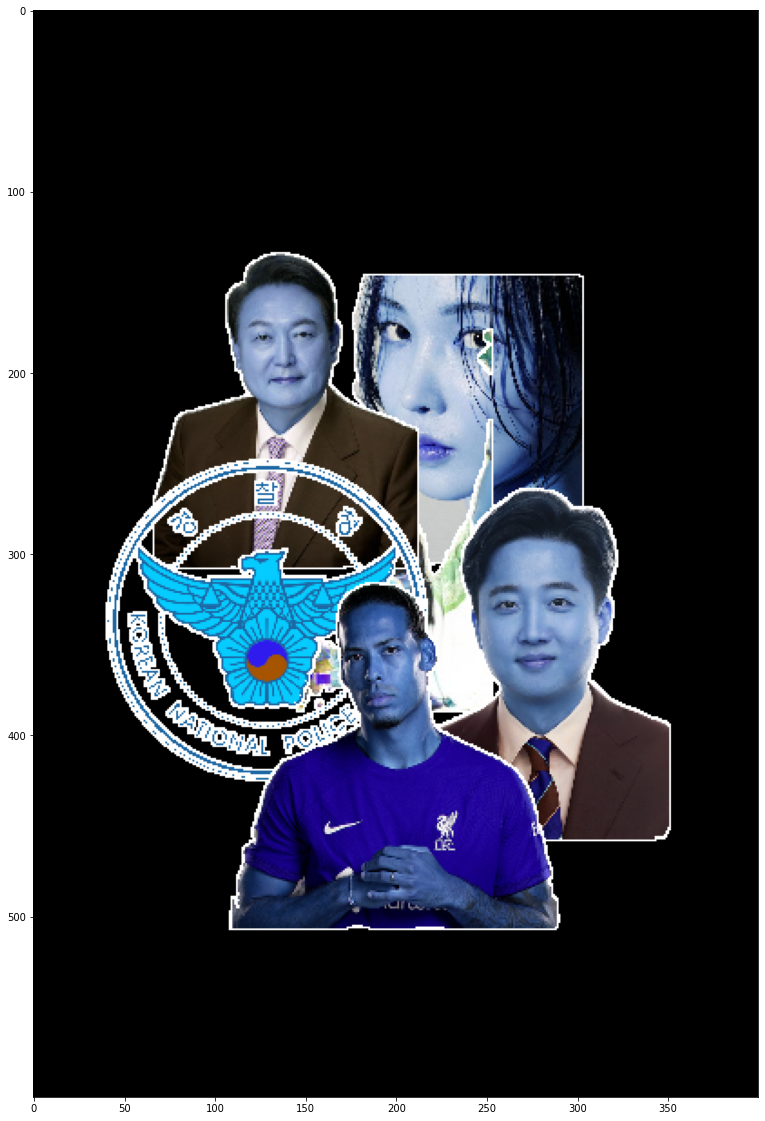

In [26]:
# 배치완료 이미지를 확인하기
background = np.zeros((600, 400, 3))
image_resize_edge.append(background)

after_padd = arrange.padding_position(image_resize_edge,index);
final_image, final_record = arrange.projection_image(after_padd)
cv2.imwrite(f'/content/drive/MyDrive/Colab Notebooks/collage/result/{datetime_text}/final.png', final_image)
plt.figure(figsize=(20,20))
plt.imshow(final_image)